### Grading Feedback

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [2]:
spam_df = spark.read.csv(get_training_filename('sms_spam.csv'), header = True, inferSchema = True)

spam_df.show(5)

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



### Grading Feedback

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [3]:
from pyspark.sql.functions import *

spam_df1 = spam_df.withColumnRenamed("type", "spam")
spam_df1 = spam_df1.withColumn("spam", when(spam_df1.spam == "spam", 1).otherwise(0))

spam_df1.show(5)

print("Shape of spam_df1:", (spam_df1.count(), len(spam_df1.columns)))

+----+--------------------+
|spam|                text|
+----+--------------------+
|   0|Go until jurong p...|
|   0|Ok lar... Joking ...|
|   1|Free entry in 2 a...|
|   0|U dun say so earl...|
|   0|Nah I don't think...|
+----+--------------------+
only showing top 5 rows

Shape of spam_df1: (5574, 2)


# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [4]:
from pyspark.ml.feature import Tokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline

tokenizer = Tokenizer().setInputCol("text").setOutputCol("words")
stop_words = requests.get("http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words").text.split()

sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered_text")

spam_df2 = Pipeline(stages = [tokenizer, sw_filter]).fit(spam_df1).transform(spam_df1)

spam_df2.show(5)

print("Shape of spam_df2:", (spam_df2.count(), len(spam_df2.columns)))

+----+--------------------+--------------------+--------------------+
|spam|                text|               words|       filtered_text|
+----+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[go, until, juron...|[jurong, point,, ...|
|   0|Ok lar... Joking ...|[ok, lar..., joki...|[ok, lar..., joki...|
|   1|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|
|   0|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|
|   0|Nah I don't think...|[nah, i, don't, t...|[nah, don't, thin...|
+----+--------------------+--------------------+--------------------+
only showing top 5 rows

Shape of spam_df2: (5574, 4)


### Grading Feedback

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [5]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

cv = CountVectorizer(minTF = 1., minDF = 5., vocabSize = 2**17)\
  .setInputCol("filtered_text")\
  .setOutputCol("tf")

idf = IDF()\
    .setInputCol("tf")\
    .setOutputCol("tfidf")

cv_pipe = Pipeline(stages=[cv, idf]).fit(spam_df2)

spam_df3 = cv_pipe.transform(spam_df2)
    
spam_df3.show(5)

print("Shape of spam_df3:", (spam_df3.count(), len(spam_df3.columns)))

print("\n10 most important words:", cv_pipe.stages[0].vocabulary[-10: ])

print("\n10 least important words:", cv_pipe.stages[0].vocabulary[0: 10])

tfidf = spam_df3.select(col('tfidf')).collect()

print("\nTotal number of columns in TFIDF:", len(tfidf[0][0]))

print("\nTotal number of rows in TFIDF:", len(tfidf[0]))

+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|spam|                text|               words|       filtered_text|                  tf|               tfidf|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[go, until, juron...|[jurong, point,, ...|(1799,[10,29,56,6...|(1799,[10,29,56,6...|
|   0|Ok lar... Joking ...|[ok, lar..., joki...|[ok, lar..., joki...|(1799,[0,23,268,4...|(1799,[0,23,268,4...|
|   1|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|(1799,[1,12,18,28...|(1799,[1,12,18,28...|
|   0|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|(1799,[0,64,71,11...|(1799,[0,64,71,11...|
|   0|Nah I don't think...|[nah, i, don't, t...|[nah, don't, thin...|(1799,[30,35,279,...|(1799,[30,35,279,...|
+----+--------------------+--------------------+--------------------+--------------------+--------------

Your model overfit explanation here: 

There won't be any model overfitting problem as the number of features in the dataset is less than the total number of observations in the dataset.

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [6]:
from pyspark.ml.classification import LogisticRegression

train_df, test_df = spam_df3.randomSplit([0.6, 0.4], seed = 0)

lr = LogisticRegression()\
    .setLabelCol("spam")\
    .setFeaturesCol("tfidf")\
    .setRegParam(0.0)\
    .setMaxIter(100)\
    .setElasticNetParam(0.)

lr_model = lr.fit(train_df)

pipe1 = Pipeline(stages = [lr])

### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [7]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

grid = ParamGridBuilder().build()

evaluator = BinaryClassificationEvaluator(labelCol = lr.getLabelCol(), rawPredictionCol = lr.getRawPredictionCol())

cv1 = CrossValidator(estimator = pipe1, estimatorParamMaps = grid, evaluator = evaluator, numFolds = 3)

fitted_cv1 = cv1.fit(train_df)

### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [8]:
evaluator.evaluate(fitted_cv1.transform(test_df))

0.9438500203274579

### Grading Feedback

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

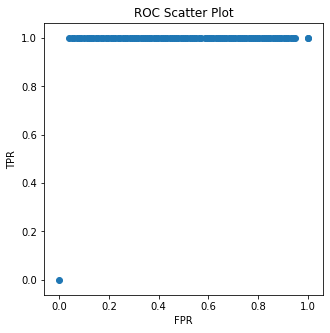

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.scatter(fitted_cv1.bestModel.stages[-1].summary.roc.select('FPR').collect(),
            fitted_cv1.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Scatter Plot')

plt.show()

### Grading Feedback

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [10]:
grid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1])\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001])\
    .build()

evaluator = BinaryClassificationEvaluator(labelCol = lr.getLabelCol(), rawPredictionCol = lr.getRawPredictionCol())

cv2 = CrossValidator(estimator = pipe1, estimatorParamMaps = grid, evaluator = evaluator, numFolds = 3)

fitted_cv2 = cv2.fit(train_df)

### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [11]:
from pyspark.sql import functions as fn
import numpy as np
import pandas as pd

print("AUC of fitted_cv2:", evaluator.evaluate(fitted_cv2.transform(test_df)),"\n")

all_models = []
for j in range(len(grid)):

    model = pipe1.fit(train_df, grid[j])
    all_models.append(model)
    
accuracies = [m\
    .transform(test_df)\
    .select(fn.avg(fn.expr("float(spam = prediction)")).alias("accuracy"))\
    .first()\
    .accuracy for m in all_models]

best_model_idx = np.argmax(accuracies)
print(grid[best_model_idx])

en_weights = fitted_cv2.bestModel.stages[-1].coefficients.toArray() 
en_coeffs_df = pd.DataFrame({'word': cv_pipe.stages[0].vocabulary, 'weight': en_weights})

print("\nTotal number of features:", len(en_weights))

print("\nNumber of features eliminated by L1 regularization:", (en_weights == 0.0).sum())

print("\nEliminated features:\n")
print(en_coeffs_df.query('weight == 0.0'))

AUC of fitted_cv2: 0.9860588925064051 

{Param(parent='LogisticRegression_9a33ddbb2dd1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_9a33ddbb2dd1', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

Total number of features: 1799

Number of features eliminated by L1 regularization: 5

Eliminated features:

          word  weight
1511      off.     0.0
1533       ran     0.0
1664     brand     0.0
1746      yoga     0.0
1760  handset?     0.0


### Grading Feedback

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [12]:
print("10 words that contribute the most to predicting spam:\n")
print(en_coeffs_df.sort_values('weight', ascending = False).head(10))

print("\n10 words that contribute the least to predicting spam:\n")
print(en_coeffs_df.sort_values('weight').head(10))

10 words that contribute the most to predicting spam:

          word    weight
1535  welcome.  0.439890
767    auction  0.431819
1552      won!  0.379239
643     apply.  0.343334
1621   amazing  0.313968
459     urgent  0.313275
1045      link  0.313142
514   message.  0.307855
1601  content.  0.307647
1275      msg:  0.305405

10 words that contribute the least to predicting spam:

               word    weight
1369  fullonsms.com -0.110904
1590         social -0.110574
1357           list -0.110082
1540           asks -0.103868
494               s -0.087536
1665         email. -0.082078
1469          share -0.080825
1749            cal -0.080211
1708          some1 -0.080195
1488           pete -0.076773


Your comments here:

- The words make sense as most of the spam SMS have words like 'won!', 'apply', 'amazing', which are part of the words that contribute the most to predicting spam.
- Likewise, normal SMS has words like 'asks', 'email.', 'cal', which are part of the words that contribute the least to predicting spam.

### Grading Feedback

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [13]:
# do not delete or change this cell

# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

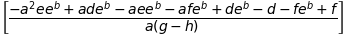

In [14]:
from sympy import *
from sympy.interactive import printing

printing.init_printing(use_latex = True)

a, b, c, d, e, f, g, h = symbols('a b c d e f g h')

e = Eq((c * g) - (c * h) + e * (( a + 1) * exp(b)) - ((d * ((a + 1) * exp(b) - 1)) / a) + ((f * ((a + 1) * exp(b) -1)) / a))

solve(e, c)

Add your latex output here such that a human readable equation is displayed for grading

### Grading Feedback